<h1>Ordinary least squares</h1>

In [1]:
import pandas as pd
import numpy as np

from statsmodels import api as smf
from scipy import stats

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from IPython.display import HTML
%matplotlib inline

In [2]:
import statsmodels
print(pd.__version__)
print(np.__version__)
print(statsmodels.__version__)

1.0.5
1.18.5
0.12.2


In [3]:
class OLS:
    """
    Метод наименьших квадратов для линейной регрессии
    Работает с pandas.DataFrame
    """
    def __init__(self):
        self.n_obs = None
        self.n_params = None
        self.df = None
        self.w = None
        self.RSS = None
        self.cov = None
        self.se_coef = None
        self.t = None
        self.pvals = []
        self.F_stat = None
    
    def fit(self, data, cols, target):
        self.cols = cols  # имена колонок на которых учимся
        self.target = target  # название таргета
        x = data[cols].values.reshape(-1, len(cols))
        y = data[target].values.reshape(-1, 1)

        self.n_obs = len(x)
        self.n_params = len(cols)
        self.df = self.n_obs - self.n_params -1

        x = np.hstack((np.ones((len(x), 1)), x))
        self.w = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)  # (X.T*X)^-1*X.T*Y

        self.RSS = np.sum((y - self.predict(x))**2)  # Residual sum of squares
        
        self.cov = np.linalg.inv(x.T.dot(x))  # ковариация
        
        self.se_coef = np.sqrt((self.RSS / (self.df)) * self.cov.diagonal())  # Standard error for coefs
        self.t = self.w.ravel() / self.se_coef  # t-статистика для гипотезы о равенстве коэффициента нулю

        cdf_t = stats.t(df=self.df).cdf(self.t)  # сколько площади под кривой распределения занимает наше значение статистики

        # это для корректного определения p-value
        for cdf in cdf_t:
            if cdf >= 0.5:
                pval = 2 * (1 - cdf)
            else:
                pval = 2 * cdf
            self.pvals.append(pval)
        
        self.r2 = self.r2_score(y, self.predict(x))  # коэффициент детерминации
        self.F_stat = (self.r2 / (1-self.r2)) * self.df / (len(self.w)-1)  # F-test that regression is useless
        
        # аналогично t-статистике
        cdf_f = stats.f(dfn=len(self.w)-1, dfd=self.df).cdf(self.F_stat)
        self.Fpval = 1 - cdf_f if cdf_f >= 0.5 else cdf_f
        
        self.resid = y - self.predict(x)
        
        self.AIC = 2 * (self.n_params+1) + self.n_obs*(np.log(2*np.pi*np.sum(self.resid**2)/self.n_obs)+1)
        self.BIC = np.log(self.n_obs) * (self.n_params+1) + self.n_obs*(np.log(2*np.pi*np.sum(self.resid**2)/self.n_obs)+1)
        return self
    
    def summary(self, alpha=0.05):
        self.alpha = alpha
        
        summary = pd.DataFrame({})
        summary['coef'] = self.w.ravel()
        summary['se_coef'] = self.se_coef
        summary['t'] = self.t
        summary['pvals'] = self.pvals
        summary[f'[{alpha/2}'] = self.w.ravel() - self.se_coef*stats.t(df=self.df).ppf(1-self.alpha/2)
        summary[f'{1-alpha/2}]'] = self.w.ravel() + self.se_coef*stats.t(df=self.df).ppf(1-self.alpha/2)
        summary['df'] = self.df
        summary['n_obs'] = self.n_obs
        summary['F_stat'] = self.F_stat
        summary['Fpval'] = self.Fpval
        summary['R-squared'] = self.r2
        summary['AIC'] = self.AIC
        summary['BIC'] = self.BIC
        summary.index = ['Intercept'] + self.cols
        return summary
    
    def predict(self, x):
        return x.dot(self.w)
    
    @staticmethod
    def r2_score(y, y_pred):
        return 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
    
    def __repr__(self):
        return f'OLS model "{self.target} ~ {" + ".join(self.cols)}"'

In [4]:
# данные о успехах в учебе
data = pd.read_csv('https://raw.githubusercontent.com/FUlyankin/matstat_coursera/main/week13_linreg/data/study.tsv', sep='\t')

In [5]:
data.head()

,CLASS,EXPN,INCOME,TEST
0,23,3,10,15
1,28,3,46,44
2,12,5,39,76
3,18,2,22,7
4,30,5,20,30


In [6]:
# Обучим мою модельку аналитического решения для регрессии
my_model = OLS()
my_model.fit(data, ['CLASS', 'INCOME', 'EXPN'], 'TEST')

OLS model "TEST ~ CLASS + INCOME + EXPN"

In [7]:
# Это посмотреть что коэффициент детерминации правильно считается
x = np.hstack((np.ones((200, 1)), data[['CLASS', 'INCOME', 'EXPN']]))
my_model.r2_score(data['TEST'], my_model.predict(x).ravel())

0.7299492138643374

In [8]:
# Вывод по модели, coef-коэффициент оценененный МНК
# se_coef-стандартная ошибка коэффициента
# t-статистика равенства коэффициента нулю
# pvals-соответствующие t-статистикам значения p-value
# 0.025 - 0.975 - доверительные интервалы для коэффициентов
# df-число степеней свободы
# n_obs-число наблюдений
# F_stat-F-статистика равенства всех коэффициентов нулю (гипотеза о бессмысленности модели в целом)
# Fpval-соответствующее F_stat значение p-value
# R-squared-коэффициент детерминации
my_model.summary()

,coef,se_coef,t,pvals,[0.025,0.975],df,n_obs,F_stat,Fpval,R-squared,AIC,BIC
Intercept,29.178617,4.847205,6.019679,8.460552e-09,19.619245,38.737989,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133
CLASS,-1.072502,0.163173,-6.572811,4.361339e-10,-1.394302,-0.750703,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133
INCOME,1.048991,0.052599,19.943008,0.000000e+00,0.945257,1.152724,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133
EXPN,2.050219,0.327487,6.260459,2.373830e-09,1.404368,2.696070,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133


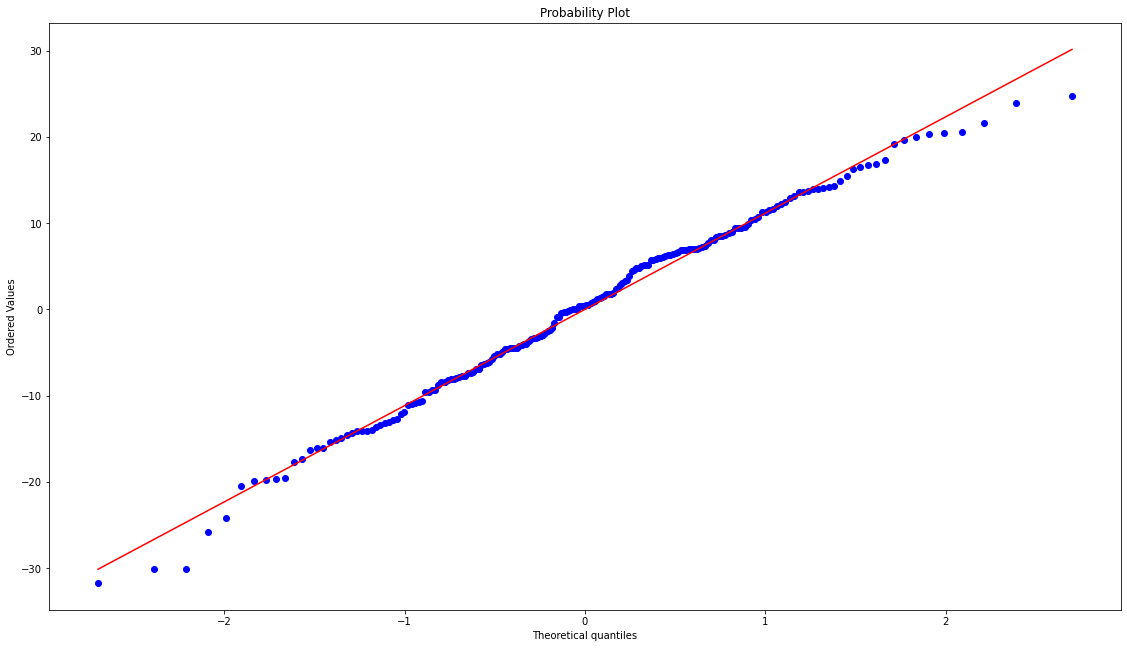

In [9]:
# QQ-plot для остатков, похоже на нормальное распределение
plt.figure(figsize=(19.20, 10.80))
stats.probplot(my_model.resid.ravel(), plot=plt)
plt.show()

In [10]:
# Тест Колмогорова-Смирнова на нормальность остатков, гипотеза о нормальности не отвергается
stats.kstest(my_model.resid.ravel(), 'norm', args=(0, np.sqrt(my_model.RSS/my_model.df)))

KstestResult(statistic=0.05469384217022022, pvalue=0.5688178220990907)

In [11]:
# Сравним стандартную ошибку остатков по выборке остатков
(my_model.resid.ravel()).std(ddof=4)  # 4 parameters

11.188707135629317

In [12]:
# И по формуле, отсюда видно сколько степеней свободы отнимается под коэффициенты
np.sqrt(my_model.RSS/my_model.df)

11.188707135629317

In [13]:
model = smf.OLS(data['TEST'].values, x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     176.6
Date:                Sat, 07 Aug 2021   Prob (F-statistic):           1.84e-55
Time:                        10:39:19   Log-Likelihood:                -764.75
No. Observations:                 200   AIC:                             1537.
Df Residuals:                     196   BIC:                             1551.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.1786      4.847      6.020      0.000      19.619      38.738
x1            -1.0725      0.163     -6.573      0.000      -1.394      -0.751
x2             1.0490      0.053     19.943      0.000       0.945       1.153
x3             2.0502      0.327      6.260      0.000       1.404       2.696
==============================================================================
Omnibus:                        2.440   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.295   Jarque-Bera (JB):                2.502
Skew:                          -0.257   Prob(JB):                        0.286
Kurtosis:                       2.811   Cond. No.                         271.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
#  можно сравнить как работает statsmodels и написанная ручками модель
my_model.summary()

,coef,se_coef,t,pvals,[0.025,0.975],df,n_obs,F_stat,Fpval,R-squared,AIC,BIC
Intercept,29.178617,4.847205,6.019679,8.460552e-09,19.619245,38.737989,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133
CLASS,-1.072502,0.163173,-6.572811,4.361339e-10,-1.394302,-0.750703,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133
INCOME,1.048991,0.052599,19.943008,0.000000e+00,0.945257,1.152724,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133
EXPN,2.050219,0.327487,6.260459,2.373830e-09,1.404368,2.696070,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133


## Bootstrap интервалы

In [15]:
def get_bootstrap_samples(x, n=1):
    """
    Функция для создания бутстреп выборок
    """
    n_obj = len(x)
    indexes = np.arange(len(x))
    choice = np.random.choice(indexes, size=(n, n_obj), replace=True)
    return x[choice]

In [16]:
# Добавим столбец единиц сразу, для свободного члена
X = np.hstack((np.ones((len(data), 1)), data.values))

In [17]:
bootstrap_x = get_bootstrap_samples(X, 100000)

In [18]:
np.empty((4, ))

array([1.19535717e-311, 1.19535717e-311, 1.19535717e-311, 1.19535717e-311])

In [19]:
# Посчитаем бутстреп средние
means = np.empty((X.shape[1], ))
for subarr in tqdm(bootstrap_x):
    means = np.vstack((means, subarr.mean(axis=0)))
means = means[1:, :]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [20]:
means

array([[ 1.   , 22.305,  5.735, 35.57 , 53.565],
       [ 1.   , 21.81 ,  5.85 , 36.11 , 57.395],
       [ 1.   , 21.54 ,  6.02 , 35.825, 56.345],
       ...,
       [ 1.   , 21.27 ,  5.985, 36.28 , 56.825],
       [ 1.   , 22.19 ,  5.755, 36.465, 55.66 ],
       [ 1.   , 21.71 ,  5.65 , 36.87 , 54.375]])

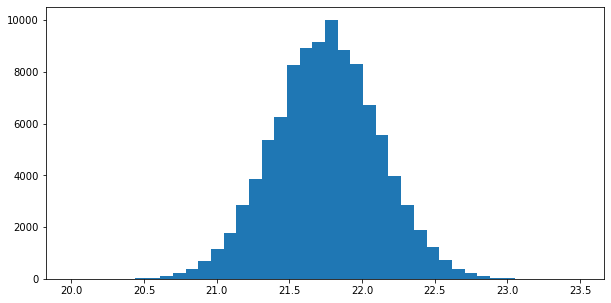

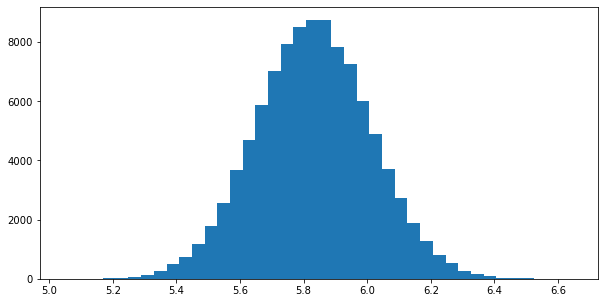

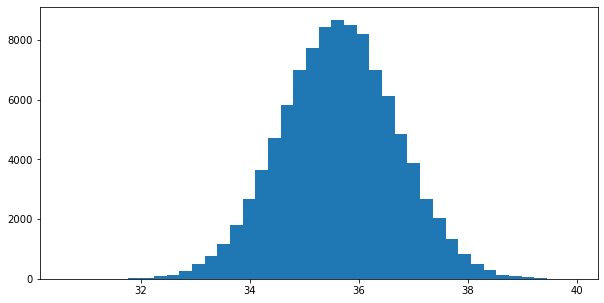

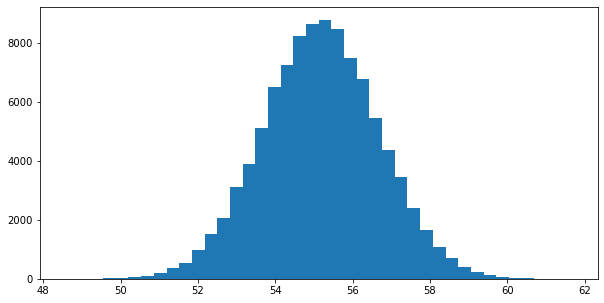

In [21]:
# ЕЕЕ ЦПТ работает (распределение средних из выборок к нормальному распределению стремится)
for i in range(1, means.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.hist(means[:, i], bins=40)
    plt.pause(1)

In [22]:
bootstrap_x[0][:5]

array([[ 1., 29.,  2., 44., 62.],
       [ 1., 18.,  8., 38., 61.],
       [ 1., 30.,  2., 57., 41.],
       [ 1., 14.,  6., 16., 44.],
       [ 1., 21.,  9., 16., 27.]])

In [25]:
# Сделаем бустреп коэффициенты, обучим регрессию на всех подвыборках
coefs = np.empty((X.shape[1]-1,))
for subarr in tqdm(bootstrap_x):
    x_train = subarr[:, :-1]
    y_train = subarr[:, -1]
    coefs_ = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train).ravel()
    coefs = np.vstack((coefs, coefs_))
coefs = coefs[1:, :]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [26]:
coefs[:5]

array([[37.08480275, -1.39007883,  1.81026097,  1.04312789],
       [41.13294241, -1.45464453,  1.94693629,  1.01352195],
       [25.66501563, -0.92185026,  2.51962001,  0.98725824],
       [28.42184012, -1.166207  ,  2.35411263,  1.0984026 ],
       [38.24952629, -1.29946277,  1.38897173,  1.04340759]])

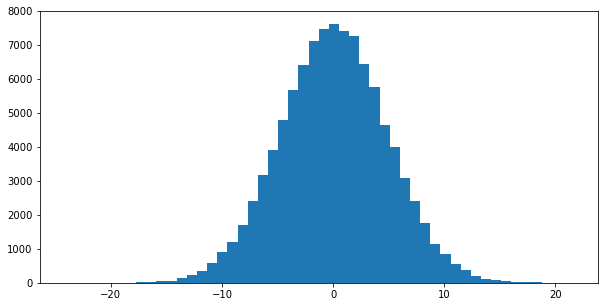

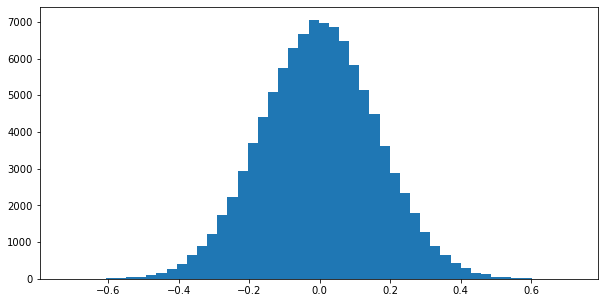

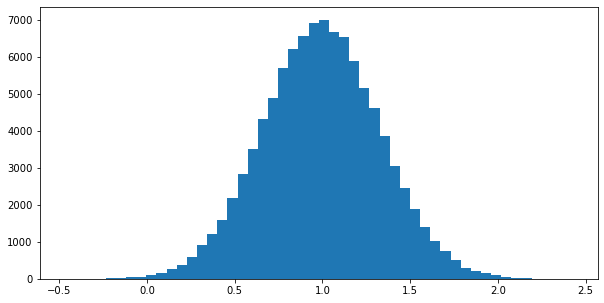

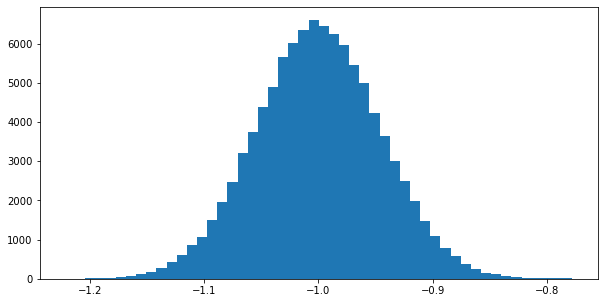

In [27]:
# Распределение коэффициентов
for i in range(0, coefs.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.hist(coefs[:, i]-my_model.w.ravel()[i], bins=50)
    plt.pause(1)

In [28]:
data.columns

Index(['CLASS', 'EXPN', 'INCOME', 'TEST'], dtype='object')

In [29]:
# Построим бутстреп доверительные интервалы, сравним с истинными
for i in range(X.shape[1]-1):
    left, right = np.quantile(coefs[:, i], [0.025, 0.975])
    
    if i == 0:
        print(f'{left} <= Intercept <= {right}')
    else:
        column = data.columns[i-1]
        print(f'{left} <= {column} <= {right}')

19.792477718249657 <= Intercept <= 38.662347848496054
-1.3948645172414156 <= CLASS <= -0.7545031240278519
1.3900860085730034 <= EXPN <= 2.697760789624726
0.942915530484288 <= INCOME <= 1.1569591913866006


In [30]:
my_model.summary()

,coef,se_coef,t,pvals,[0.025,0.975],df,n_obs,F_stat,Fpval,R-squared,AIC,BIC
Intercept,29.178617,4.847205,6.019679,8.460552e-09,19.619245,38.737989,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133
CLASS,-1.072502,0.163173,-6.572811,4.361339e-10,-1.394302,-0.750703,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133
INCOME,1.048991,0.052599,19.943008,0.000000e+00,0.945257,1.152724,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133
EXPN,2.050219,0.327487,6.260459,2.373830e-09,1.404368,2.696070,196,200,176.596469,1.110223e-16,0.729949,1537.496863,1550.690133


### Интервалы очень близкими получаются, бутстреп хорош, но вычислительно может быть затратным

In [31]:
with open('./style.css') as f:
    style = f.read()
HTML(style)